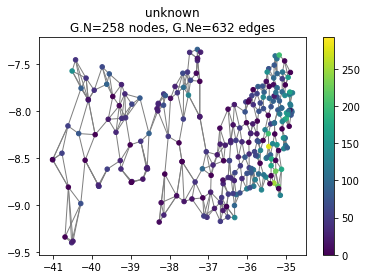

In [2]:
###
import csv
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt
from pygsp import *
from scipy.spatial import distance

#####################################
columns_signal = defaultdict(list) 

with open('PE_pluviometria_extra.csv') as f:
    reader = csv.reader(f)
    next(reader)
    for row in reader:
        for (i,v) in enumerate(row):
            columns_signal[i].append(v)
            

l = len(columns_signal[0])

columns_coordinates = defaultdict(list) 

with open('Coordenadas_das_estacoes_extra.csv') as f:
    reader = csv.reader(f)
    next(reader)
    for row in reader:
        for (i,v) in enumerate(row):
            columns_coordinates[i].append(v)
            

k = len(columns_coordinates[0])

#####################################
Data_matrix = np.zeros((l,3))

for j in range (0,l):
    if (columns_signal[3][j] != '-'):
        Data_matrix[j][0] = float(columns_coordinates[2][j])
        Data_matrix[j][1] = float(columns_coordinates[3][j])
        Data_matrix[j][2] = float(columns_signal[3][j])
    else:
        Data_matrix[j][0] = float(columns_coordinates[2][j])
        Data_matrix[j][1] = float(columns_coordinates[3][j])
        Data_matrix[j][2] = 0.0

coordinates = np.zeros((len(Data_matrix),2))
signal = np.zeros((len(Data_matrix),1))

for i in range(0,len(Data_matrix)):
    coordinates[i][1] = Data_matrix[i][0]
    coordinates[i][0] = Data_matrix[i][1]
    signal[i] = Data_matrix[i][2]
    
#####################################
def m_adj(coords,k):
    
    Adj_K = np.zeros((len(coords),len(coords)))
    Aux = np.zeros((len(coords),1))
    aux = 0

    ind=np.zeros((k,1))
    for x in range(0,len(coords)):
        for y in range(0,len(coords)):
            v = [coords[x][0],coords[x][1]]
            w = [coords[y][0],coords[y][1]]
            dst = distance.euclidean(v,w)
            Aux[y]=dst
        ind = sorted(Aux)[1:k+1]
        for i in range(0,k):
            ind[i] = np.where(Aux == ind[i])
        for j in range(0,k):
            aux = ind[j][0]
            Adj_K[x][int(aux)] = np.exp((-Aux[ind[j]]**2))
            Adj_K[int(aux)][x] = Adj_K[x][int(aux)]

    
    return(Adj_K)

A = m_adj(coordinates,4)

#####################################
G = graphs.Graph(A)

G.set_coordinates(coordinates)

plotting.plot_signal(G, signal, vertex_size = 20)

         Current function value: 7868.903418
         Iterations: 100
         Function evaluations: 4993
         Gradient evaluations: 128


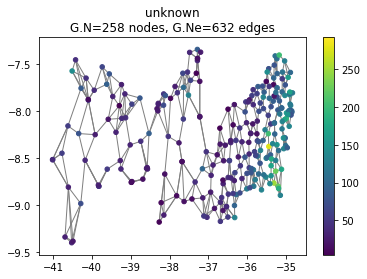

In [3]:
###
from scipy.optimize import minimize
from numpy import array
from numpy.linalg import norm

def L(Adj):
    
    degree = np.zeros((len(Adj),len(Adj))) 

    colsum = Adj.sum(axis=0)
    rowsum = Adj.sum(axis=1)

    for j in range(0, len(Adj)):
        degree[j][j] = colsum[j] + rowsum[j]

    L = degree - Adj
    
    return(L)

Lp = L(A) 

#####################################
ind = []

for j in range (0,l):
    if columns_signal[3][j] == '-':
        ind.append(j)

#####################################
s_est = []

def fun(n):
    
    sig = []
    
    for j in range (0,len(signal)):
        sig.append(signal[j])
        
    global s_est
    
    for i in range(len(n)):
        sig[ind[i]] = n[i]
            
    s_est = sig
    R = array(np.dot(Lp, s_est))
    return(norm(R))

#####################################
x0 = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
res = minimize(fun, x0, method='BFGS', options={'gtol': 1e-6, 'disp': True})
res.x

#####################################
plotting.plot_signal(G, array(s_est), vertex_size = 20)